In [1]:
import numpy as np
import os
import pickle

# IMPORTO I DATI PER VOTTIGNASCO

# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")
v_test_images_dates = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_image_sequences_dates.npy"
v_test_normalization_factors_std_path  = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy")
v_test_normalization_factors_mean_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy")

# Carica l'array numpy dai file
vottignasco_test_OHE         = np.load(v_test_OHE_path)
vottignasco_test_image       = np.load(v_test_image_path)
vottignasco_test_dates       = np.load(v_test_target_dates_path)
vottignasco_test_image_dates = np.load(v_test_images_dates)
vott_target_test_std         = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean        = np.load(v_test_normalization_factors_mean_path)


print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))

105
105
105


In [13]:
import matplotlib.pyplot as plt

def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel/frame inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)

def plot_combined_curves(all_errors_insertion, all_errors_deletion, title="", save_path=""):
    # Creazione della figura e dei due subplot (1 riga, 2 colonne)
    fig, axs = plt.subplots(1, 2, figsize=(11, 5))

    # Plot per la curva di inserimento
    max_len_insertion = max(map(len, all_errors_insertion))
    padded_array_insertion = np.full((len(all_errors_insertion), max_len_insertion), np.nan)
    for i, row in enumerate(all_errors_insertion):
        padded_array_insertion[i, :len(row)] = row  # Riempie solo le parti esistenti
    #mean_errors_for_insertion_vott = np.nanmean(all_errors_insertion, axis=0)
    mean_errors_for_insertion_vott = np.nanmean(padded_array_insertion, axis=0)

    #x_insertion = np.arange(0, mean_errors_for_insertion_vott.shape[0])
    x_insertion = np.linspace(0, 1, mean_errors_for_insertion_vott.shape[0])
    auc_insertion = calculate_auc(x_insertion, mean_errors_for_insertion_vott)
    auc_text_insertion = f'AUC = {auc_insertion:.2f}'
    axs[0].plot(x_insertion, mean_errors_for_insertion_vott, label=f'Error Curve, {auc_text_insertion}')
    #axs[0].scatter(x_insertion, mean_errors_for_insertion_vott, color='blue', zorder=3)


    axs[0].fill_between(x_insertion, mean_errors_for_insertion_vott, color='skyblue', alpha=0.4)
    axs[0].set_xlabel('Fraction of pixels inserted')
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].set_title('Mean Insertion Metric Curve')
    axs[0].legend()

    # Plot per la curva di cancellazione
    max_len_deletion = max(map(len, all_errors_deletion))
    padded_array_deletion = np.full((len(all_errors_deletion), max_len_deletion), np.nan)
    for i, row in enumerate(all_errors_deletion):
        padded_array_deletion[i, :len(row)] = row  # Riempie solo le parti esistenti
    mean_errors_for_deletion_vott = np.nanmean(padded_array_deletion, axis=0)
    #mean_errors_for_deletion_vott = np.nanmean(all_errors_deletion, axis=0)

    #x_deletion = np.arange(0, mean_errors_for_deletion_vott.shape[0])
    x_deletion = np.linspace(0, 1, mean_errors_for_deletion_vott.shape[0])
    auc_deletion = calculate_auc(x_deletion, mean_errors_for_deletion_vott)
    auc_text_deletion = f'AUC = {auc_deletion:.2f}'

    axs[1].plot(x_deletion, mean_errors_for_deletion_vott, label=f'Error Curve, {auc_text_deletion}')
    #axs[1].scatter(x_deletion, mean_errors_for_deletion_vott, color='red', zorder=3)
    axs[1].fill_between(x_deletion, mean_errors_for_deletion_vott, color='lightcoral', alpha=0.4)
    axs[1].set_xlabel('Fraction of pixels removed')
    axs[1].set_ylabel('Mean Squared Error')
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].set_title('Deletion Mean Metric Curve')
    axs[1].legend()

    # Aggiungi il titolo globale
    plt.suptitle(title, fontsize=16)
    # Mostra i plot
    plt.tight_layout()

    # Salva la figura con DPI 400
    #plt.tight_layout()
    #plt.subplots_adjust(top=0.85)  # Per evitare che il titolo si sovrapponga ai grafici
    #plt.savefig(save_path, dpi=400)

    plt.show()

    return auc_insertion, auc_deletion

def plot_auc_comparison(all_param_auc_insertion, all_param_auc_deletion):
    """
    Plotta due scatter plot affiancati (1x2) per confrontare le AUC delle metriche insertion e deletion.

    Args:
    - all_param_auc_insertion (list): Lista di tuple/liste [AUC, configurazione] per insertion.
    - all_param_auc_deletion (list): Lista di tuple/liste [AUC, configurazione] per deletion.
    """

    # Separare le AUC e le configurazioni per insertion
    auc_values_insertion = [item[0] for item in all_param_auc_insertion]
    configurations_insertion = [item[1] for item in all_param_auc_insertion]

    # Separare le AUC e le configurazioni per deletion
    auc_values_deletion = [item[0] for item in all_param_auc_deletion]
    configurations_deletion = [item[1] for item in all_param_auc_deletion]

    # Impostare la figura con due subplot affiancati (1x2)
    plt.figure(figsize=(15, 6))

    # Primo subplot: Insertion
    plt.subplot(1, 2, 1)
    plt.scatter(configurations_insertion, auc_values_insertion, color='blue')
    plt.title('AUC Mean Insertion Values')
    plt.xlabel('Configurations')
    plt.ylabel('AUC')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)

    # Secondo subplot: Deletion
    plt.subplot(1, 2, 2)
    plt.scatter(configurations_deletion, auc_values_deletion, color='red')
    plt.title('AUC Mean Deletion Values')
    plt.xlabel('Configurations')
    plt.ylabel('AUC')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)

    # Ottimizzare il layout
    plt.tight_layout()
    plt.show()

def plot_multiple_auc_comparisons(data, labels=None, title='AUC Comparison for Different Parameters'):
    """
    Plotta uno scatter plot comparativo delle AUC per più combinazioni di parametri.

    Args:
    - data (list of lists): Ogni sotto-lista ha coppie [AUC, configurazione]
    - labels (list): Etichette per ogni serie di dati (opzionale)
    - title (str): Titolo del grafico
    """

    plt.figure(figsize=(12, 6))

    # Se non ci sono labels, crea etichette generiche (Set 1, Set 2, ...)
    if labels is None:
        labels = [f'Set {i+1}' for i in range(len(data))]

    # Iterare sui dati e plottare ciascun set
    for i, auc_param_list in enumerate(data):
        auc_values = [item[0] for item in auc_param_list]
        configurations = [item[1] for item in auc_param_list]
        plt.scatter(configurations, auc_values, label=labels[i])

    # Personalizzazioni del plot
    plt.title(title)
    plt.xlabel('Configurations')
    plt.ylabel('AUC')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Parameter Sets")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [2]:
import pickle

path_to_load_results = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/results/01_marco_spatial_rise_original_20250308184613/rise_original_spatial_results_all_setup.pkl"
# Load della lista results
with open(path_to_load_results, 'rb') as file:
  result_rise_s_all = pickle.load(file)

In [ ]:
# Legenda nr_setup 
# h,w=(1,2) con p: 0.1...0.9 -> nr_setup=0..8
# h,w=(2,1) con p: 0.1...0.9 -> nr_setup=9..17
# h,w=(2,2) con p: 0.1...0.9 -> nr_setup=18..26
# h,w=(2,3) con p: 0.1...0.9 -> nr_setup=27..34
# h,w=(2,4) con p: 0.1...0.9 -> nr_setup=35..44

In [32]:
nr_instance = 0
nr_setup    = 39

result = result_rise_s_all[nr_setup]

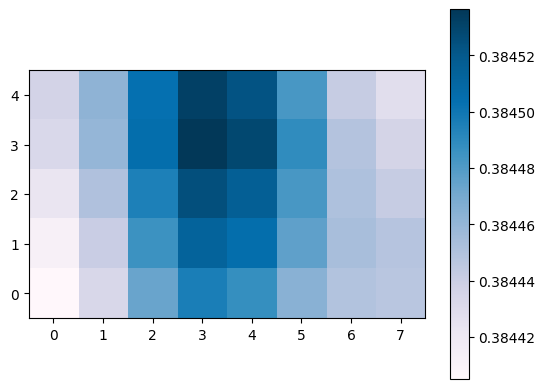

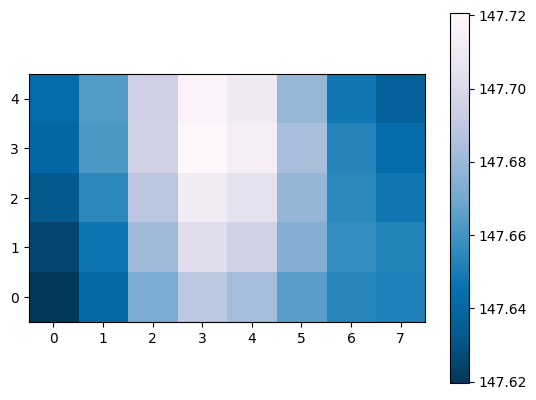

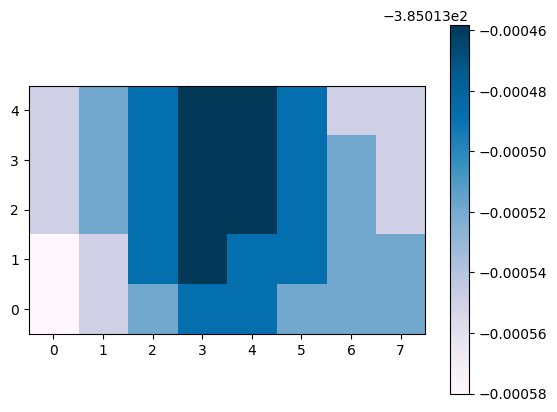

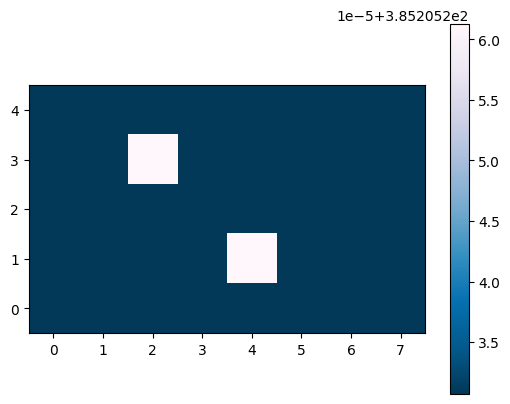

In [37]:
nr_instance = 0 
for index_i in range(1,5):
    s_i = result["saliency_maps"][nr_instance,index_i-1,:]
    cmap = "PuBu"

    if index_i in [2,4]:
        cmap="PuBu_r"

    plt.imshow(s_i, cmap=cmap, origin="lower")
    plt.colorbar()
    plt.show()

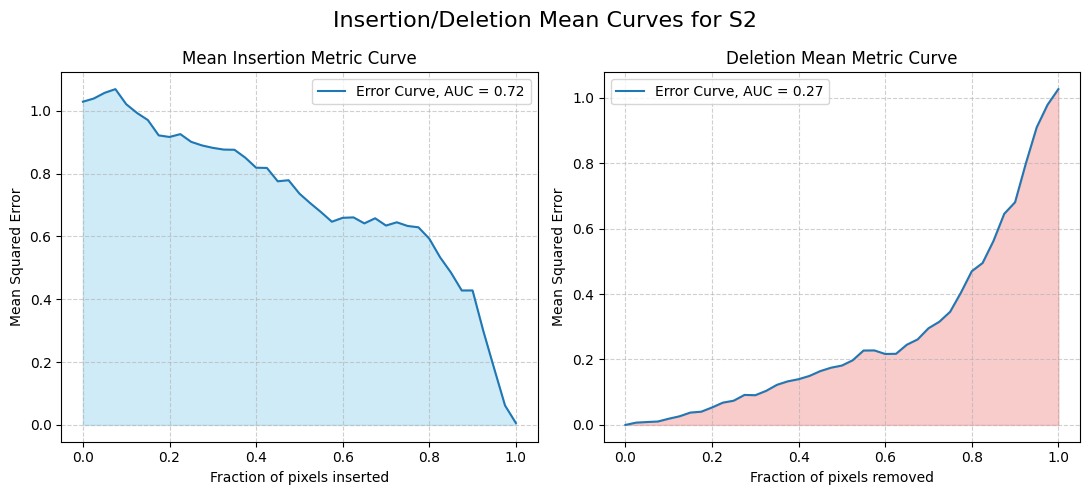

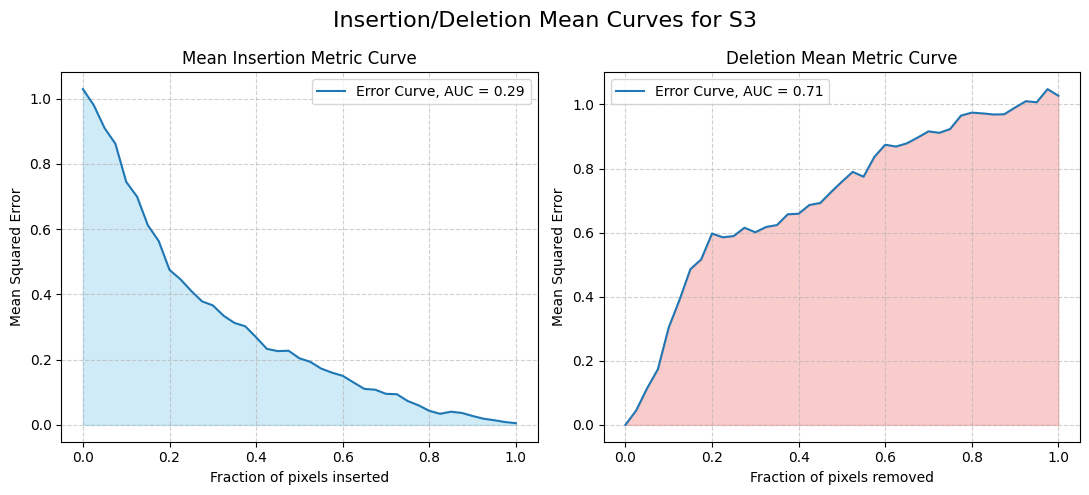

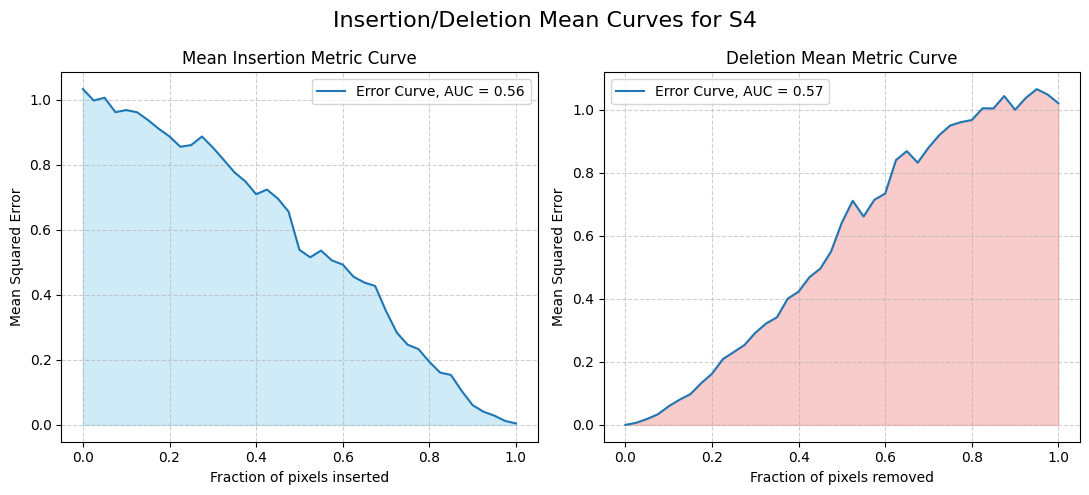

In [33]:
for index_i in range(2,5):

    s_i_errors_insertion = result["errors_insertion"][:,index_i-1,:]
    s_i_errors_deletion  = result["errors_deletion"][:,index_i-1,:]

    plot_combined_curves(s_i_errors_insertion, s_i_errors_deletion, title=f"Insertion/Deletion Mean Curves for S{index_i}")